In [1]:
#  1. Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC

import warnings
warnings.filterwarnings('ignore')

In [2]:
#  2. Load Dataset
df = pd.read_csv("train.csv")
df.drop("sl_no", axis=1, inplace=True)

In [9]:
# Show data info
print("Initial Dataset Info:\n")
print(df.info())

Initial Dataset Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   gender          215 non-null    int64  
 1   ssc_p           215 non-null    float64
 2   ssc_b           215 non-null    object 
 3   hsc_p           215 non-null    float64
 4   hsc_b           215 non-null    object 
 5   hsc_s           215 non-null    object 
 6   degree_p        215 non-null    float64
 7   degree_t        215 non-null    object 
 8   workex          215 non-null    object 
 9   etest_p         215 non-null    float64
 10  specialisation  215 non-null    object 
 11  mba_p           215 non-null    float64
 12  status          215 non-null    object 
dtypes: float64(5), int64(1), object(7)
memory usage: 22.0+ KB
None


status
Placed        148
Not Placed     67
Name: count, dtype: int64


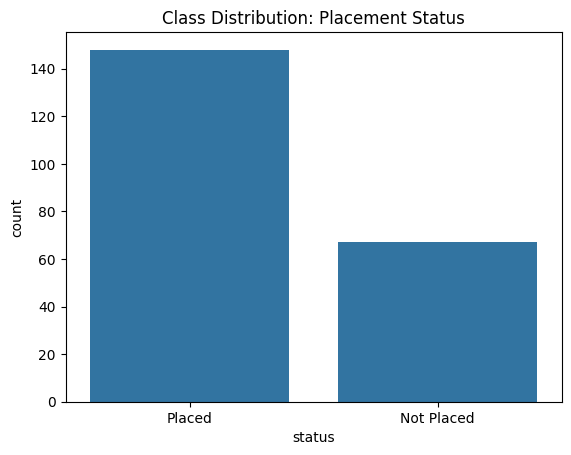

In [5]:
# 3. EDA
print(df["status"].value_counts())
sns.countplot(x='status', data=df)
plt.title("Class Distribution: Placement Status")
plt.show()


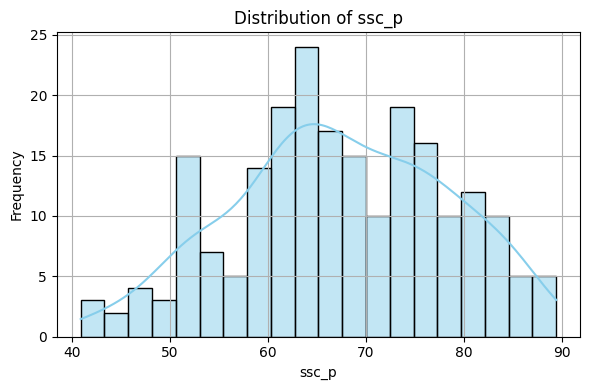

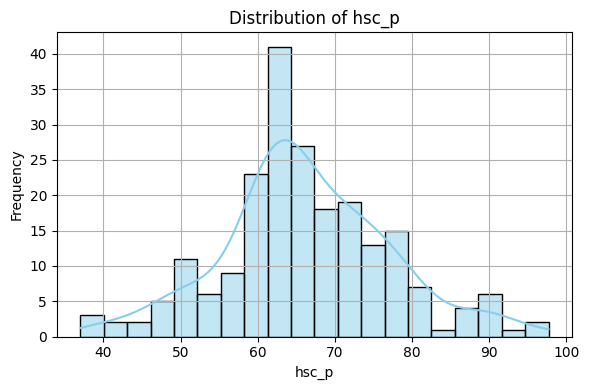

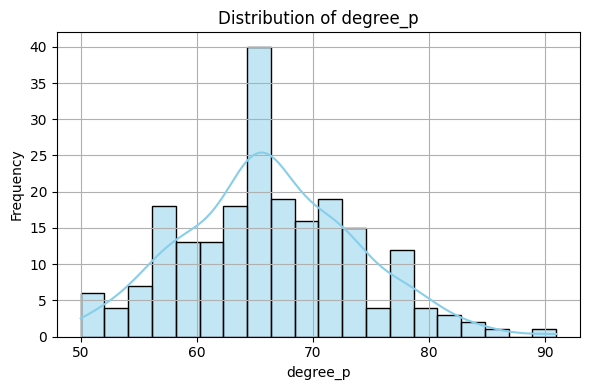

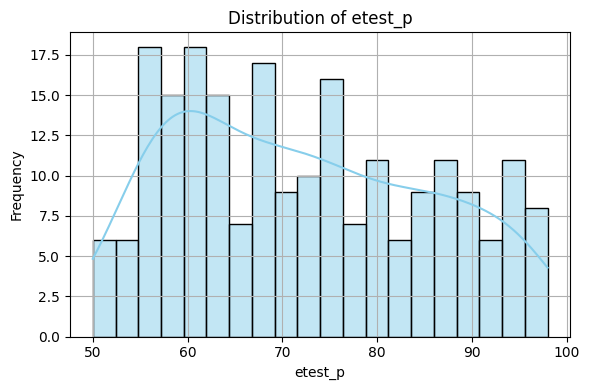

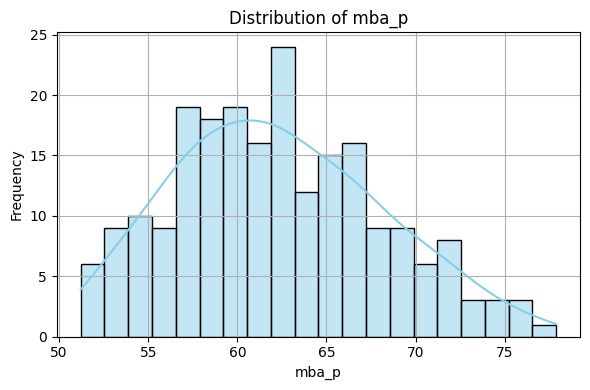

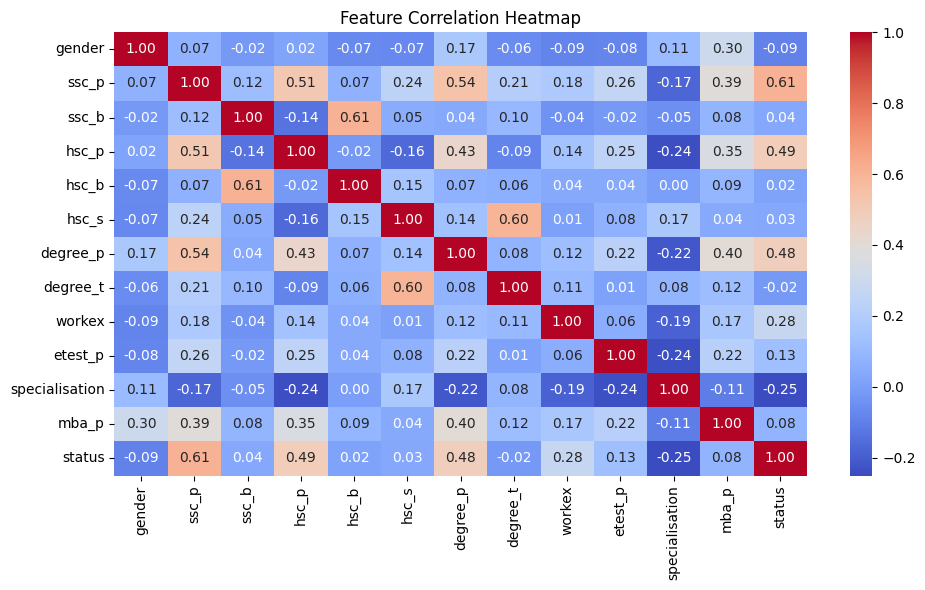

In [25]:
#Visualize distributions of numerical features
num_cols = ['ssc_p', 'hsc_p', 'degree_p', 'etest_p', 'mba_p']

for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], bins=20, kde=True, color='skyblue')
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 3.2: Visualize correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

In [6]:
#4. Check for nulls
print(df.isnull().sum())


gender             0
ssc_p              0
ssc_b              0
hsc_p              0
hsc_b              0
hsc_s              0
degree_p           0
degree_t           0
workex             0
etest_p            0
specialisation     0
mba_p              0
status             0
salary            67
dtype: int64


In [7]:
# Drop salary column as it's not useful for predicting status and contains many NaNs
df.drop("salary", axis=1, inplace=True)


In [8]:
# Check for nulls again after dropping
print(df.isnull().sum())

gender            0
ssc_p             0
ssc_b             0
hsc_p             0
hsc_b             0
hsc_s             0
degree_p          0
degree_t          0
workex            0
etest_p           0
specialisation    0
mba_p             0
status            0
dtype: int64


In [11]:
#  Step 5: Encode Categorical Features
label_enc = LabelEncoder()
for col in df.select_dtypes(include="object").columns:
    df[col] = label_enc.fit_transform(df[col])

In [12]:
# Step 6: Train/Test Split and Scaling
X = df.drop("status", axis=1)
y = df["status"]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [19]:
# 7. Define evaluation function
def evaluate_model(name, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return [acc, prec, rec, f1]

In [20]:
# 8. Hyperparameter grids for tuning
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs']
}

param_grid_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [4, 5, 6, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

param_grid_svc = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf']
}


In [22]:
# 9. Function to perform GridSearchCV tuning
def tune_model(model, param_grid):
    grid = GridSearchCV(model, param_grid, cv=5, scoring='f1', n_jobs=-1)
    grid.fit(X_train, y_train)
    print(f"Best params for {model.__class__.__name__}: {grid.best_params_}")
    return grid.best_estimator_

# 10. Tune models
lr_tuned = tune_model(LogisticRegression(max_iter=50), param_grid_lr)
rf_tuned = tune_model(RandomForestClassifier(random_state=42), param_grid_rf)
svc_tuned = tune_model(SVC(probability=True), param_grid_svc)


Best params for LogisticRegression: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
Best params for RandomForestClassifier: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best params for SVC: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}



Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.67      0.72        21
           1       0.85      0.91      0.88        44

    accuracy                           0.83        65
   macro avg       0.81      0.79      0.80        65
weighted avg       0.83      0.83      0.83        65



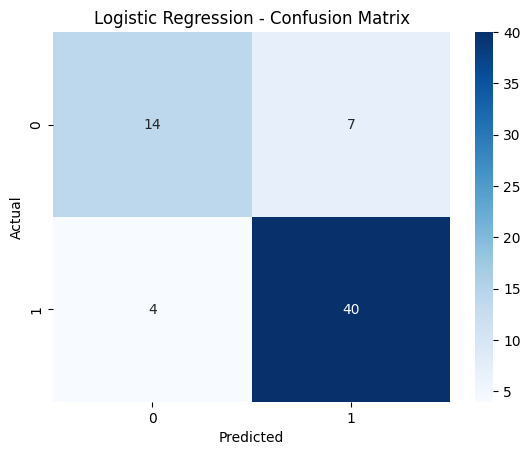


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.48      0.61        21
           1       0.79      0.95      0.87        44

    accuracy                           0.80        65
   macro avg       0.81      0.72      0.74        65
weighted avg       0.81      0.80      0.78        65



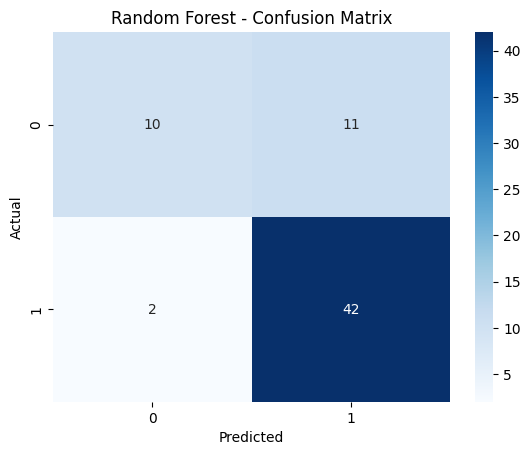


Support Vector Machine Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.43      0.56        21
           1       0.78      0.95      0.86        44

    accuracy                           0.78        65
   macro avg       0.80      0.69      0.71        65
weighted avg       0.79      0.78      0.76        65



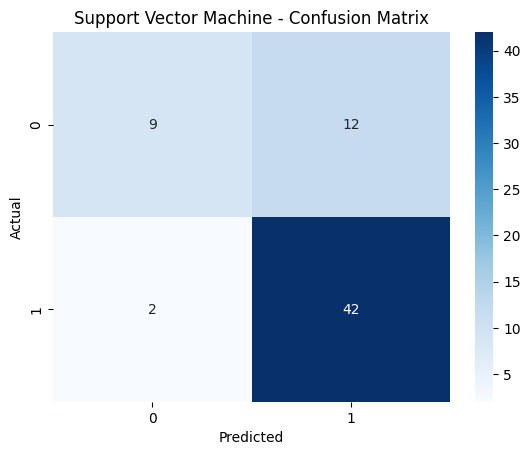


Voting Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.48      0.59        21
           1       0.79      0.93      0.85        44

    accuracy                           0.78        65
   macro avg       0.78      0.70      0.72        65
weighted avg       0.78      0.78      0.77        65



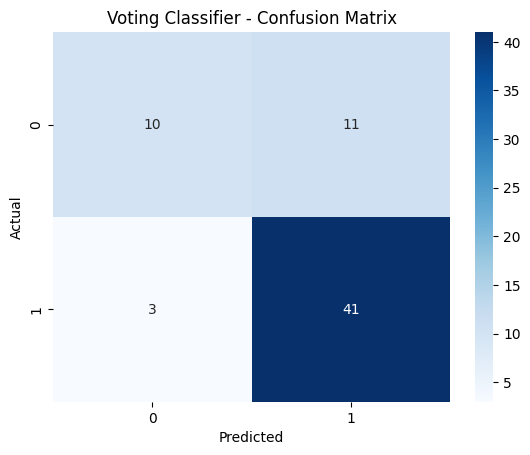

In [23]:
# 11. Evaluate tuned models
models_tuned = {
    "Logistic Regression": lr_tuned,
    "Random Forest": rf_tuned,
    "Support Vector Machine": svc_tuned
}

metrics_tuned = {}
for name, model in models_tuned.items():
    metrics_tuned[name] = evaluate_model(name, model)

# 12. Voting Classifier with tuned models
voting_clf_tuned = VotingClassifier(estimators=[
    ('lr', lr_tuned),
    ('rf', rf_tuned),
    ('svc', svc_tuned)
], voting='soft')

metrics_tuned["Voting Classifier"] = evaluate_model("Voting Classifier", voting_clf_tuned)



Tuned Model Comparison Table:
                        Accuracy  Precision    Recall  F1 Score
Logistic Regression     0.830769   0.851064  0.909091  0.879121
Random Forest           0.800000   0.792453  0.954545  0.865979
Support Vector Machine  0.784615   0.777778  0.954545  0.857143
Voting Classifier       0.784615   0.788462  0.931818  0.854167


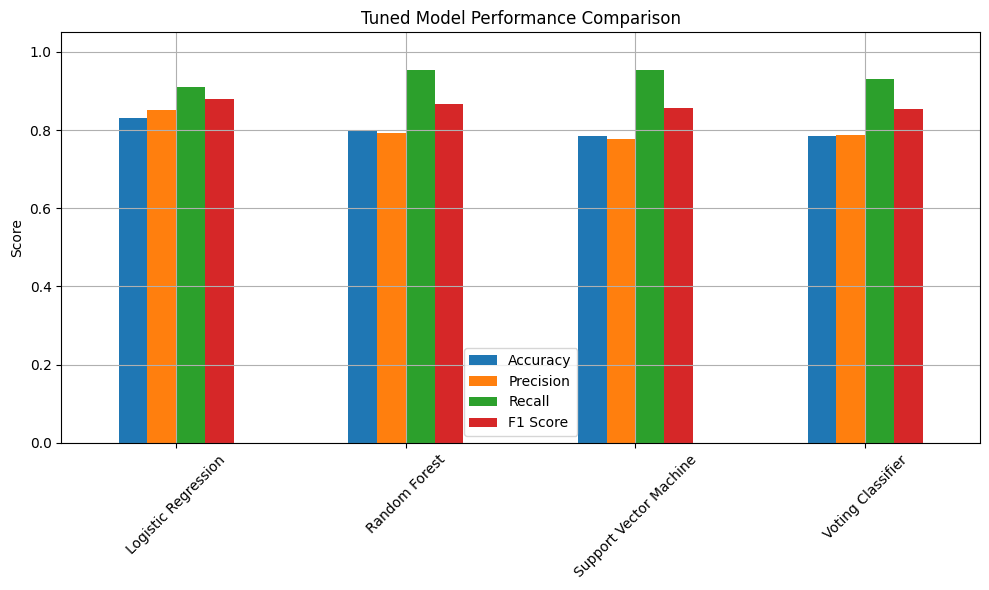

In [24]:
# 13. Compare tuned model performance
metrics_df_tuned = pd.DataFrame(metrics_tuned, index=["Accuracy", "Precision", "Recall", "F1 Score"]).T
print("\nTuned Model Comparison Table:")
print(metrics_df_tuned)

metrics_df_tuned.plot(kind='bar', figsize=(10, 6))
plt.title("Tuned Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()